In [80]:
import numpy as np
import os
import tifffile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from sklearn.ensemble import RandomForestClassifier

In [100]:
data_dir = "classifier_data/"
image_dir = data_dir + "sentinel_raster_maps/"
target_dir = data_dir + "target_raster_maps/"

no_images = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(image_dir))))
    
no_targets = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(target_dir))))

assert no_images == no_targets

images = []
targets = []

shp = tifffile.imread("{}image_{}.tiff".format(image_dir, "0")).shape
tilesize = shp[0]
no_bands = shp[2]

X = np.empty((tilesize**2*no_images, no_bands))
y = np.empty(tilesize**2*no_images)

for i in range(no_images):
    #Sentinel band (image) raster - X
    image_data = tifffile.imread("{}image_{}.tiff".format(image_dir, i))
    images.append(image_data)
    
    X[i*tilesize**2:(i+1)*tilesize**2, :] = np.reshape(image_data, (tilesize**2, no_bands))
    
    #Target raster - y
    target = Image.open("{}target_{}.tiff".format(target_dir, i))
    #print(np.array(target.getdata()).shape)
    targets.append(np.reshape(list(target.getdata()), (tilesize, tilesize)))
    
    y[i*tilesize**2:(i+1)*tilesize**2] = np.array(target.getdata())
    
print(X.shape)
print(y.shape)

(24576, 10)
(24576,)


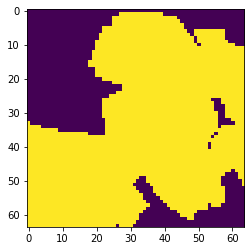

In [76]:
a_target = Image.open('{}/target_3.tiff'.format(target_dir)) #tifffile complains about codecs if you try to use that here
target_pixel_data = np.reshape(list(a_target.getdata()), (64,64))
plt.imshow(target_pixel_data)

(64, 64, 10)


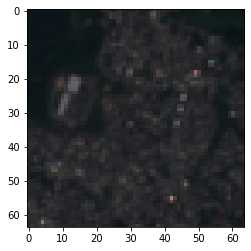

In [77]:
a_image = tifffile.imread('{}/image_3.tiff'.format(image_dir))
print(a_image.shape)
image_pixel_data = a_image[:,:,0:3] #RGB Selected as bands 1:3
plt.imshow(image_pixel_data)

In [97]:
no_images

['image_3.tiff',
 'image_4.tiff',
 'image_5.tiff',
 'image_0.tiff',
 'image_2.tiff',
 'image_1.tiff']